In [1]:
# ========================
# 1. IMPORTAÇÃO DE BIBLIOTECAS
# ========================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# ========================
# 2. CARREGAMENTO E LIMPEZA DOS DADOS
# ========================
# Caminho para o arquivo (ajuste se necessário)
df = pd.read_csv("../data/Environment_Temperature_change_E_All_Data_NOFLAG.csv", encoding="ISO-8859-1")

# Remover espaços dos nomes das colunas
df.columns = df.columns.str.strip()

# Identificar colunas de anos
id_vars = ["Area", "Months", "Element", "Unit"]
year_columns = [col for col in df.columns if col.startswith("Y") and col[1:].isdigit()]

# Transformar de formato wide para long
df_long = df.melt(id_vars=id_vars, value_vars=year_columns,
                  var_name="Year", value_name="Value")

# Limpeza de dados
df_long["Year"] = df_long["Year"].str[1:].astype(int)  # Remove o "Y" de "Y1961", "Y1962" etc.
df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")
df_long = df_long.dropna(subset=["Value"])

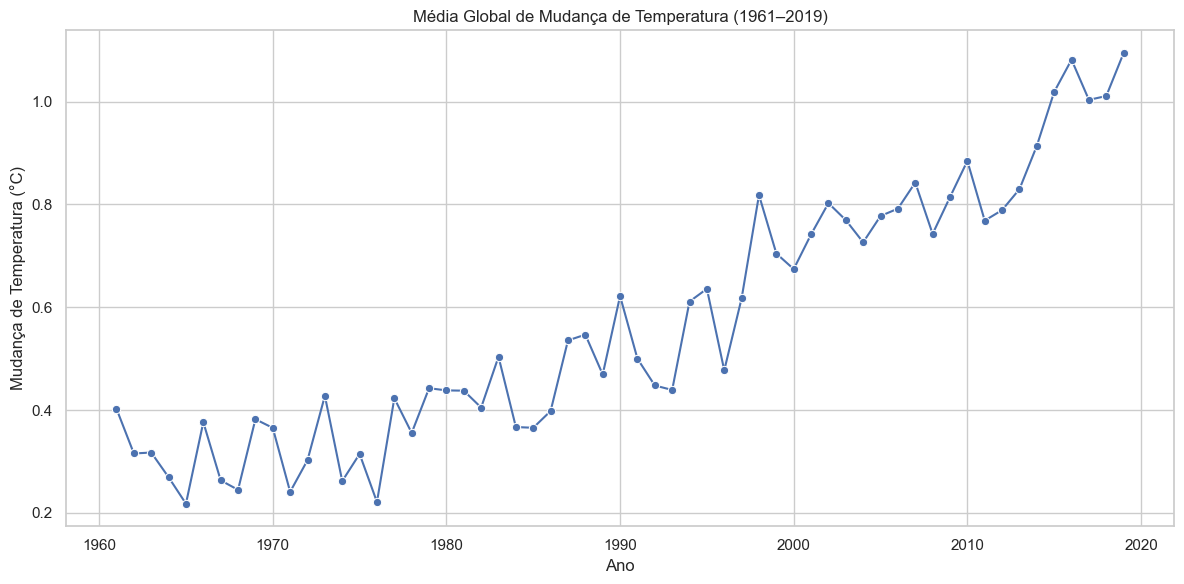

In [3]:
# ========================
# 3. ANÁLISE EXPLORATÓRIA
# ========================

# 3.1. Evolução global da temperatura ao longo do tempo
global_avg = df_long.groupby("Year")["Value"].mean().reset_index()

plt.figure()
sns.lineplot(data=global_avg, x="Year", y="Value", marker="o")
plt.title("Média Global de Mudança de Temperatura (1961–2019)")
plt.xlabel("Ano")
plt.ylabel("Mudança de Temperatura (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\evert\AppData\Local\Temp\ipykernel_25408\1455826807.py:9: UserWarning: Glyph 150 (\x96) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\evert\OneDrive - puc-rio.br\4º Período\INF1032 - Introdução à Ciência de Dados\Projeto - Aquecimento Global\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 150 (\x96) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


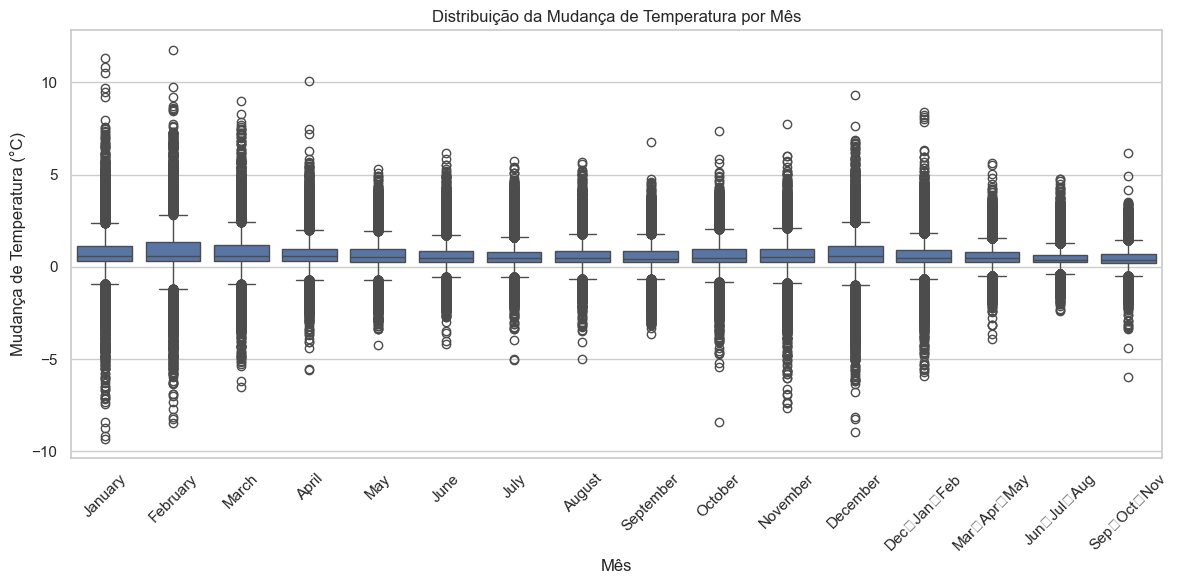

In [4]:
# 3.2. Boxplot das variações por mês (excluindo "Meteorological year")
plt.figure()
sns.boxplot(data=df_long[df_long["Months"] != "Meteorological year"],
            x="Months", y="Value")
plt.xticks(rotation=45)
plt.title("Distribuição da Mudança de Temperatura por Mês")
plt.xlabel("Mês")
plt.ylabel("Mudança de Temperatura (°C)")
plt.tight_layout()
plt.show()

C:\Users\evert\AppData\Local\Temp\ipykernel_25408\2288271675.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, palette="Reds_r")


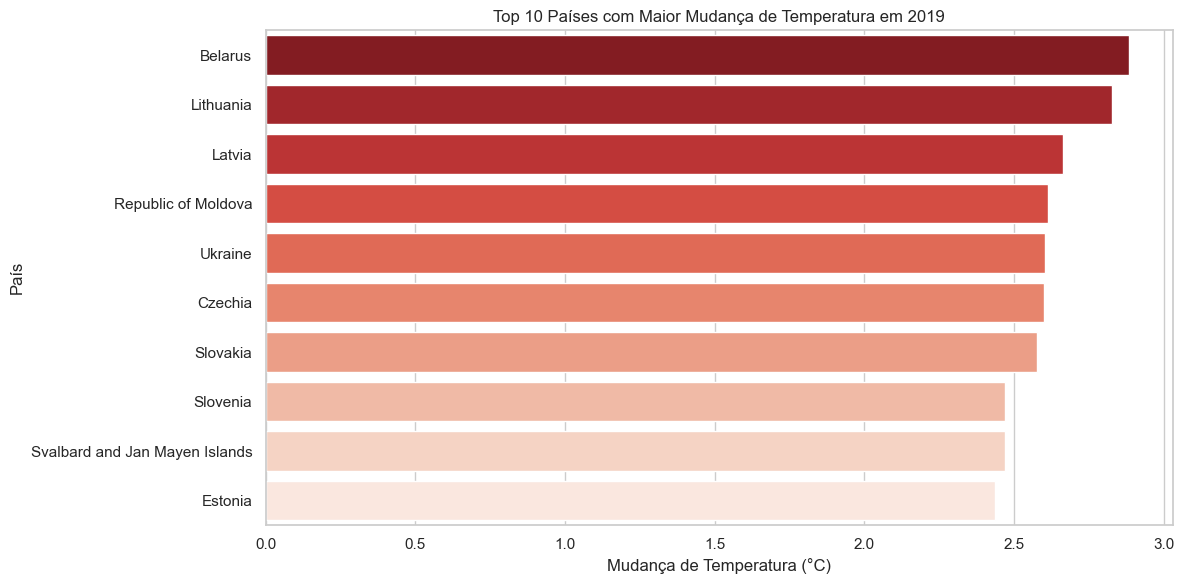

In [5]:
# 3.3. Top 10 países mais afetados em 2019
df_2019 = df_long[df_long["Year"] == 2019]
top_10 = df_2019.groupby("Area")["Value"].mean().sort_values(ascending=False).head(10)

plt.figure()
sns.barplot(x=top_10.values, y=top_10.index, palette="Reds_r")
plt.title("Top 10 Países com Maior Mudança de Temperatura em 2019")
plt.xlabel("Mudança de Temperatura (°C)")
plt.ylabel("País")
plt.tight_layout()
plt.show()

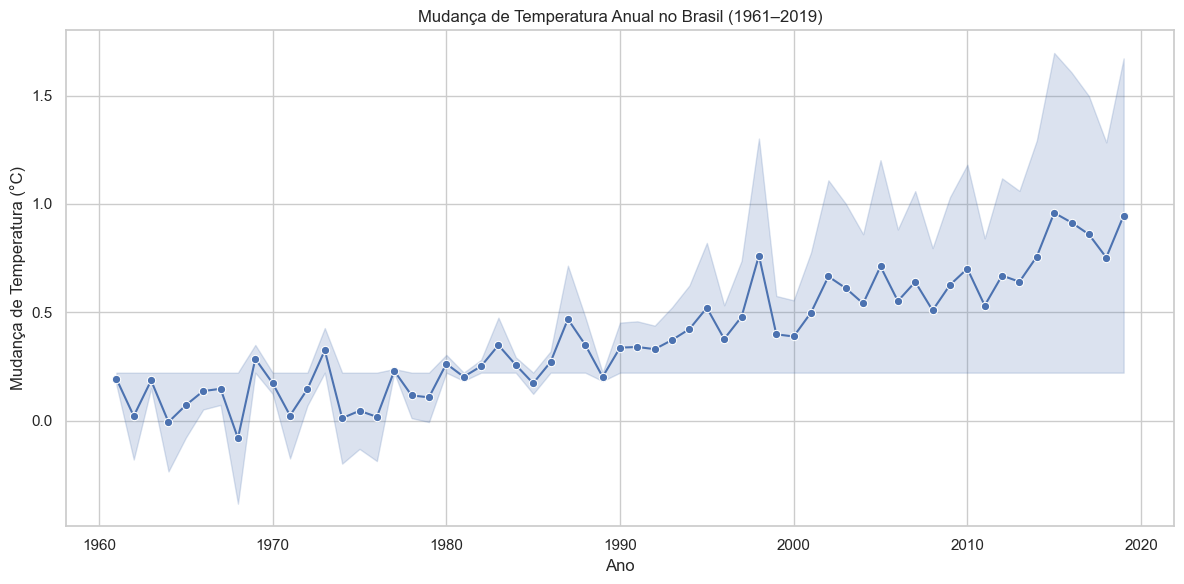

In [6]:
# 3.4. Média de temperatura por região ao longo do tempo (exemplo: Brasil)
brasil = df_long[(df_long["Area"] == "Brazil") & (df_long["Months"] == "Meteorological year")]

plt.figure()
sns.lineplot(data=brasil, x="Year", y="Value", marker="o")
plt.title("Mudança de Temperatura Anual no Brasil (1961–2019)")
plt.xlabel("Ano")
plt.ylabel("Mudança de Temperatura (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# Engenharia de Features

# 1. Delta Anual de Temperatura por País
df_long["Delta_Anual"] = df_long.sort_values(["Area", "Year"]).groupby("Area")["Value"].diff()

# 2. Desvio em relação à média histórica por país
media_historica = df_long.groupby("Area")["Value"].transform("mean")
df_long["Desvio_Historico"] = df_long["Value"] - media_historica

# 3. Média Móvel de 5 anos
df_long["Media_Movel_5"] = (
    df_long.sort_values(["Area", "Year"])
           .groupby("Area")["Value"]
           .transform(lambda x: x.rolling(5, min_periods=1).mean())
)

# 4. Variação Máxima Mensal por Ano e País (armazenada em outro DataFrame)
var_mensal = df_long.groupby(["Area", "Year"])["Value"].agg(["max", "min"]).reset_index()
var_mensal["Variacao_Mensal"] = var_mensal["max"] - var_mensal["min"]

# 5. Z-Score por País
df_long["Z_Score"] = df_long.groupby("Area")["Value"].transform(lambda x: (x - x.mean()) / x.std())
